# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics

## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). It is a fictional dataset created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/wa_fn_usec_hr_employee_attrition_tsv.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Install CatBoost

In [ ]:
!pip -qq install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


### Import Required Packages

In [ ]:
import numpy as np  # Used for numerical operations and working with arrays (efficient computation).

import pandas as pd  # For data manipulation, analysis, and handling tabular data (e.g., DataFrames).

import seaborn as sns  # Provides a high-level interface for statistical data visualization (like heatmaps, plots).

from matplotlib import pyplot as plt  # Core plotting library for creating graphs and figures.

# roc_auc_score,  -> Calculates the ROC AUC score (a metric for binary classification performance).
#    accuracy_score ->  Computes the accuracy of the model.
#    confusion_matrix -> Creates a confusion matrix to evaluate model predictions.
#    f1_score -> Computes the F1 score (harmonic mean of precision and recall).
#    ConfusionMatrixDisplay -> Visualizes the confusion matrix as a plot.
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

# Splits datasets into training and testing sets
from sklearn.model_selection import train_test_split

# Scales features to a specific range (like 0 to 1)
from sklearn.preprocessing import MinMaxScaler


# Gradient boosting classifiers from different libraries:
from lightgbm import LGBMClassifier  # LightGBM: Fast gradient boosting algorithm.
from xgboost import XGBClassifier  # XGBoost: Popular gradient boosting library for structured data.
from catboost import CatBoostClassifier, metrics  # CatBoost: Gradient boosting library optimized for categorical features.

import warnings  # Manages and filters warnings (to avoid unnecessary messages during execution).
warnings.filterwarnings("ignore")  # Ignores all warnings for a cleaner output.

# Sets a consistent plotting style for matplotlib:
plt.style.use('fivethirtyeight')

# Adjusts pandas display settings to show more columns in DataFrames:
pd.set_option('display.max_columns', 100)

# Ensures plots display inline in Jupyter or Colab notebooks:
%matplotlib inline

# hp -> Defines the search space for hyperparameters.
# tpe -> Tree-structured Parzen Estimator (an optimization algorithm).
# Trials -> Stores the results of optimization trials.
# STATUS_OK -> Status indicator for successful trials.
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin  # Function to minimize (find optimal hyperparameters).

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Part-A

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [ ]:
ibm_df = pd.read_csv('/content/wa_fn_usec_hr_employee_attrition_tsv.csv')
ibm_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
ibm_df.shape

(1470, 35)

In [ ]:
# Check for features having consistent data across samples

for col in ibm_df.columns:
    if ibm_df[col].nunique() == 1:
        print(col)

employeecount
over18
standardhours


In [ ]:
ibm_df.over18.value_counts()

,count
over18,
Y,1470


In [ ]:
ibm_df.employeecount.value_counts()

,count
employeecount,
1,1470


In [ ]:
ibm_df.standardhours.value_counts()

,count
standardhours,
80,1470


The above features that is employeecount, standardhours, and over18 has only one value throughout the records. Hence, they will be dropped.


In [ ]:
ibm_df = ibm_df.drop(['employeenumber', 'employeecount', 'over18', 'standardhours'], axis=1)
ibm_df.head(5)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [ ]:
# Shape of dataframe
ibm_df.shape

(1470, 31)

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

### Description

In [ ]:
# Create a dataframe to save description of feature columns such as o. of samples, missing values, data type, range
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])

numerical = []
categorical = []

for col in ibm_df.columns:
    obs = ibm_df[col].size                                                      # total samples/rows in the column

    missing_count = ibm_df[col].isna().sum()
    p_nan = round(missing_count/obs, 2)                                         # percentage missing values in the column
    num_nan = f'{p_nan}% ({missing_count}/{obs})'                               # string format to show missing value in percetage and fraction

    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'       # data type of the column
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)       # save numeric and categoric features' names in different lists

    # string format to show the range of the column
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'

    # Fill entries in the dataframe
    description[col] = [obs, num_nan, dtype, rng]


pd.set_option('display.max_columns', 100)
display(description)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,2 labels,11-25,3-4,1-4,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


The data isn't missing any values and we can spend more time on comparing different gradient boosted tree algorithms. First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

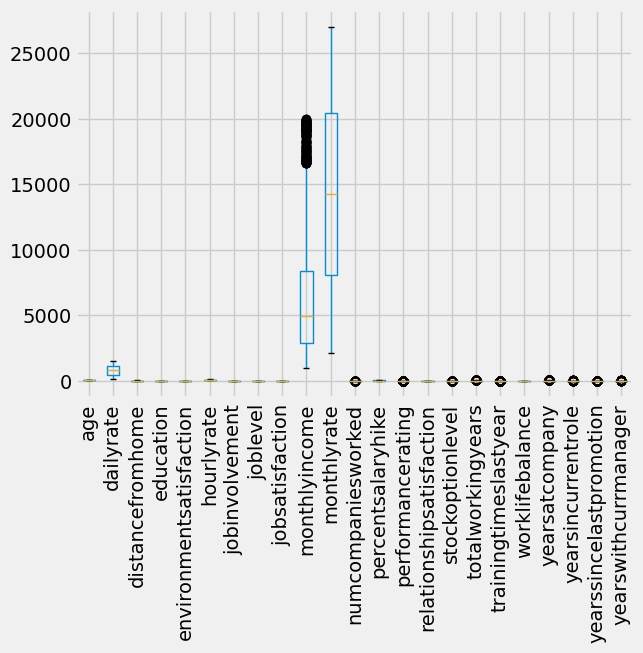

In [ ]:
# Check for outliers
ibm_df.boxplot(rot = 90)
plt.show()

### Handing outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

**Explanation**: This code handles outliers by capping them to the upper and lower whisker values using the IQR method.

1. outlier_colms: List of columns where outliers will be handled.
2. ibm_df1: A copy of the original DataFrame.
3. handle_outliers function:
  * Calculates Q1 (25%), Q3 (75%), and IQR = Q3 - Q1.
  * Sets lower bound = Q1 - 1.5 * IQR, upper bound = Q3 + 1.5 * IQR.
  * For each value in the column:
    * If greater than upper bound, set to upper bound.
    * If less than lower bound, set to lower bound.

The function is applied to all columns in outlier_colms to ensure extreme values are adjusted

In [ ]:
outlier_colms = ['monthlyincome', 'numcompaniesworked', 'stockoptionlevel',  'performancerating', 'totalworkingyears',
                 'trainingtimeslastyear', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']
ibm_df1 = ibm_df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

for colm in outlier_colms:
    ibm_df1 = handle_outliers(ibm_df1, colm)

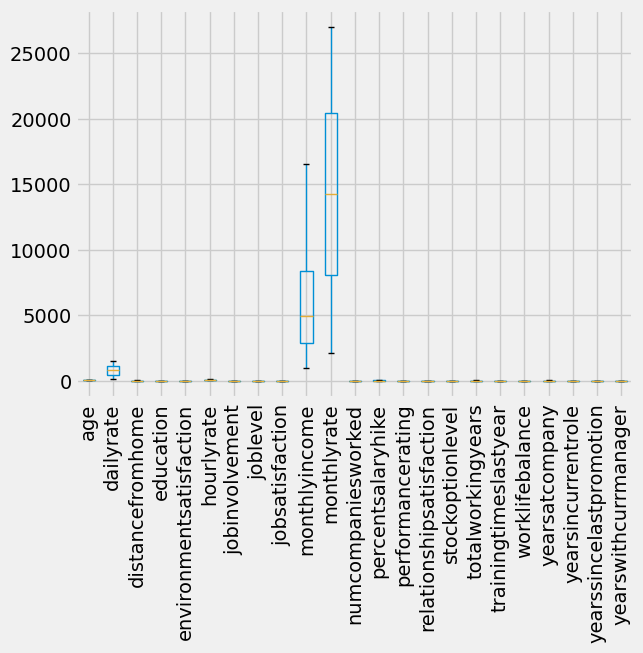

In [ ]:
# Recheck for outliers
ibm_df1.boxplot(rot = 90)
plt.show()

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

In [ ]:
# Count of unique values in Attrition column
attrition_values = ibm_df1['attrition'].value_counts()
attrition_values

,count
attrition,
No,1233
Yes,237


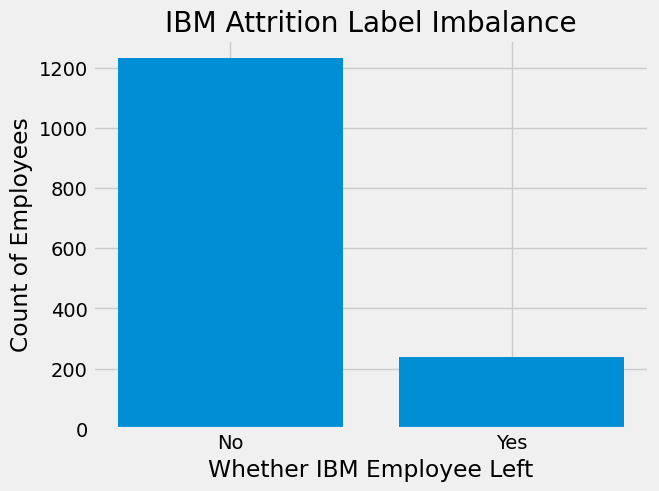

In [ ]:
# Plot barplot
plt.bar(attrition_values.index, attrition_values.values)
plt.title('IBM Attrition Label Imbalance') # Adding Title
plt.xlabel('Whether IBM Employee Left') # Adding label for x-axis
plt.ylabel('Count of Employees') # Adding label for y-axis
plt.show() # Display the plot

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

In [ ]:
# List of selected features to visualize relationships
features = ['monthlyincome', 'attrition', 'yearsatcompany',
            'yearswithcurrmanager', 'joblevel', 'totalworkingyears']

# Create a pairplot to explore pairwise relationships between features
# 'diag_kind' is set to 'kde' for kernel density estimation on diagonal plots. KDE (Kernel Density Estimation) is a technique
# to estimate the probability distribution of continuous data by smoothing data points with a kernel function (like Gaussian).
# It provides a smooth curve, offering better insights than histograms by avoiding binning issues. The bandwidth controls the
# smoothness—higher bandwidth means more smoothing, lower bandwidth means more detail.

# 'hue' distinguishes data points by the 'attrition' feature for better comparison
pairplot = sns.pairplot(ibm_df1[features], diag_kind='kde', hue='attrition')

# Display the plot
plt.show()


From the results it can see that the data has an imbalance in target labels. It has about a 6:1 *No* attrition label compared to *Yes*. The effect of the imbalance really shows up in the pairplots where the *yes* markers in the scatter plots are all but drowned out, though this would be less of a problem if the classes were more distinct. To test the model a smart thing to do would be to look at the confusion matrix and see how well the model performed on the minority class, *yes*.

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

In [ ]:
# Visualize heatmap
# Set the figure size for the heatmap plot
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize correlations between numerical features
# 'corr()' computes the correlation matrix of the selected numerical columns
sns.heatmap(ibm_df1.loc[:, numerical].corr())

# Add a title to the heatmap
plt.title('Correlation Among IBM Employee Attrition Numerical Features')

# Display the heatmap
plt.show()


In the pairplot, from the diagonal distributions it seems that there are no features that have drastically different distributions between the classes.

Lastly, plot the correlations between the features to look for colinear relationships. These are usually a problem for GBDTs but if there are many features with high correlation, some feature engineering can be done.

# Part-B

### Preparing the Validation Data

In [ ]:
# Split into training and validation set
# 'test_size=0.05' means 5% of the data will be used for testing
# 'stratify=ibm_df1['attrition']' ensures both sets have similar class distribution for 'attrition'
# 'random_state=123' ensures reproducibility of the split
train_ibm_df, test_ibm_df = train_test_split(ibm_df1,
                                             test_size=0.05,
                                             stratify=ibm_df1['attrition'],
                                             random_state=123)

# Display the shapes of the training and testing datasets
train_ibm_df.shape, test_ibm_df.shape


((1396, 31), (74, 31))

In [ ]:
# Check the distribution of the class labels
print("Attrition train")
print(train_ibm_df['attrition'].value_counts()/len(train_ibm_df))
print("Attrition test")
print(test_ibm_df['attrition'].value_counts()/len(test_ibm_df))

Attrition train
attrition
No     0.838825
Yes    0.161175
Name: count, dtype: float64
Attrition test
attrition
No     0.837838
Yes    0.162162
Name: count, dtype: float64


In [ ]:
test_ibm_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
1294,41,No,Travel_Rarely,447,Research & Development,5,3,Life Sciences,2,Male,85,4,2,Healthcare Representative,2,Single,6870,15530,3.0,No,12,3,1,0.0,11.0,3.0,1,3,2.0,1.0,2.0
634,25,No,Travel_Rarely,141,Sales,3,1,Other,3,Male,98,3,2,Sales Executive,1,Married,4194,14363,1.0,Yes,18,3,4,0.0,5.0,3.0,3,5,3.0,0.0,3.0
60,32,No,Travel_Rarely,427,Research & Development,1,3,Medical,1,Male,33,3,2,Manufacturing Director,4,Married,6162,10877,1.0,Yes,22,3,2,1.0,9.0,3.0,3,9,8.0,7.0,8.0
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1.0,Yes,20,3,2,1.0,6.0,0.5,3,6,2.0,0.0,3.0
424,57,No,Travel_Rarely,210,Sales,29,3,Marketing,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3.0,No,12,3,3,1.0,28.5,3.0,2,1,0.0,0.0,0.0


In [ ]:
categorical

['attrition',
 'businesstravel',
 'department',
 'educationfield',
 'gender',
 'jobrole',
 'maritalstatus',
 'overtime']

In [ ]:
# Handling categorical features in test set
test_dummy = pd.get_dummies(test_ibm_df[categorical], drop_first=True)
test_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
# Concat encoded features
test_ibm_df = pd.concat([test_ibm_df, test_dummy], axis=1)

# Drop original categorical columns
test_ibm_df.drop(columns = categorical, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,0.0,11.0,3.0,1,3,2.0,1.0,2.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,0.0,5.0,3.0,3,5,3.0,0.0,3.0,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,1.0,9.0,3.0,3,9,8.0,7.0,8.0,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,1.0,6.0,0.5,3,6,2.0,0.0,3.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,1.0,28.5,3.0,2,1,0.0,0.0,0.0,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
# Rename target column
test_ibm_df.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,0.0,11.0,3.0,1,3,2.0,1.0,2.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,0.0,5.0,3.0,3,5,3.0,0.0,3.0,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,1.0,9.0,3.0,3,9,8.0,7.0,8.0,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,1.0,6.0,0.5,3,6,2.0,0.0,3.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,1.0,28.5,3.0,2,1,0.0,0.0,0.0,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
# Features
test_x = test_ibm_df.drop('attrition', axis=1)

# Target label
test_y = test_ibm_df['attrition']

test_x.shape, test_y.shape

((74, 44), (74,))

# Hyperopt (Optional)

In [ ]:
# Define a function to organize and extract relevant results from hyperparameter trials
def org_results(trials, hyperparams, model_name):
    fit_idx = -1  # Initialize index to track the matching trial

    # Loop through all trials to find the one matching the given hyperparameters
    for idx, fit in enumerate(trials):
        hyp = fit['misc']['vals']  # Extract the hyperparameters from the current trial
        xgb_hyp = {key: [val] for key, val in hyperparams.items()}  # Format given hyperparameters
        if hyp == xgb_hyp:  # If a match is found, store the index and break the loop
            fit_idx = idx
            break

    # Calculate the total parameter search time from the first to the last trial
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])

    # Extract and round key performance metrics from the matching trial
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    F1 = round(trials[fit_idx]['result']['f1 score'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    # Organize the results into a dictionary with model details and performance metrics
    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'f1_score': F1,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }

    # Return the organized results
    return results

Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks.

Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [ ]:
cbo_data = train_ibm_df.copy()
cbo_data.shape

(1396, 31)

In [ ]:
# Handling categorical features in train set
cbo_dummy = pd.get_dummies(cbo_data[categorical], drop_first=True)
cbo_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
cbo_data = pd.concat([cbo_data, cbo_dummy], axis=1)
cbo_data.drop(columns = categorical, inplace=True)
cbo_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Rename target column
cbo_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
cbo_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Features
x_df = cbo_data.drop('attrition', axis=1)

# Target label
y_df = cbo_data['attrition']

x_df.shape, y_df.shape

((1396, 44), (1396,))

### SMOTE (Optional)

In [ ]:
# Import the SMOTE (Synthetic Minority Oversampling Technique) class from imblearn
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object to handle class imbalance
oversample = SMOTE()

# Apply SMOTE to generate synthetic samples for the minority class
# 'fit_resample()' returns the balanced feature (x_df1) and target (y_df1) datasets
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

In [ ]:
y_df1.value_counts()

,count
attrition,
True,1171
False,1171


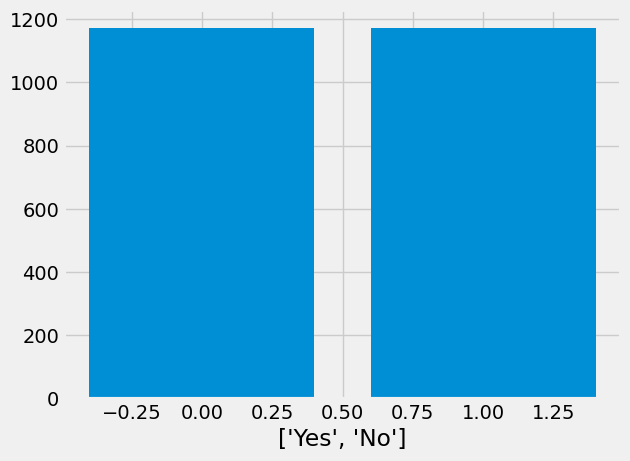

In [ ]:
plt.bar(y_df1.value_counts().index, y_df1.value_counts().values)
plt.xlabel(["Yes", "No"])
plt.show()

After implementing SMOTE, x_df1 and y_df1 are the independent features and target labels simultaeneously.

If SMOTE is to be applied they can be used while training the model.

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.

In [ ]:
# def cat_objective(space):

#     cboost = CatBoostClassifier(
#     eval_metric  = 'AUC',
#     learning_rate = space['learning_rate'],
#     iterations = space['iterations'],
#     depth = space['depth'],
#     l2_leaf_reg = space['l2_leaf_reg'],
#     border_count = space['border_count']
#     )

#     cboost.fit(x_df1, y_df1,
#             cat_features=None)

#     predictions = cboost.predict(test_x)
#     test_preds = cboost.predict_proba(test_x)[:,1]
#     train_preds = cboost.predict_proba(x_df1)[:,1]

#     train_auc = roc_auc_score(y_df1, train_preds)
#     test_auc = roc_auc_score(test_y, test_preds)
#     accuracy = accuracy_score(test_y, predictions)
#     F1 = f1_score(test_y, predictions)

#     return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
#             'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1}

Hyperparameter tuning technique to optimize parameters for CatBoost (Optional).

In [ ]:
# trials = Trials()
# space = {
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
#     'iterations': hp.quniform('iterations', 25, 1000, 25),
#     'depth': hp.quniform('depth', 1, 16, 1),
#     'border_count': hp.quniform('border_count', 30, 220, 5),
#     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
# }

# cboost_hyperparams = fmin(fn = cat_objective,
#                  max_evals = 150,
#                  trials = trials,
#                  algo = tpe.suggest,
#                  space = space
#                  )

# cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
# display(cbo_results)

In [ ]:
# Create CatBoost model
cboost = CatBoostClassifier(learning_rate = 1,
                            depth = 1,
                            scale_pos_weight = 6,
                            l2_leaf_reg = 8,
                            border_count = 65)

In [ ]:
cboost_dft = CatBoostClassifier()

In [ ]:
cboost_dft.fit(x_df, y_df, cat_features = None)

Learning rate set to 0.01188
0:	learn: 0.6859968	total: 48.7ms	remaining: 48.6s
1:	learn: 0.6765181	total: 52.1ms	remaining: 26s
2:	learn: 0.6687945	total: 54.9ms	remaining: 18.2s
3:	learn: 0.6611176	total: 57.6ms	remaining: 14.3s
4:	learn: 0.6535012	total: 60.3ms	remaining: 12s
5:	learn: 0.6463303	total: 63ms	remaining: 10.4s
6:	learn: 0.6397001	total: 65.6ms	remaining: 9.31s
7:	learn: 0.6314022	total: 68.4ms	remaining: 8.47s
8:	learn: 0.6241989	total: 71.1ms	remaining: 7.83s
9:	learn: 0.6169518	total: 73.7ms	remaining: 7.3s
10:	learn: 0.6110061	total: 76.5ms	remaining: 6.87s
11:	learn: 0.6032202	total: 79.2ms	remaining: 6.52s
12:	learn: 0.5978247	total: 81.9ms	remaining: 6.22s
13:	learn: 0.5913540	total: 84.5ms	remaining: 5.95s
14:	learn: 0.5845327	total: 87.2ms	remaining: 5.73s
15:	learn: 0.5788628	total: 89.9ms	remaining: 5.53s
16:	learn: 0.5731824	total: 92.5ms	remaining: 5.35s
17:	learn: 0.5670416	total: 95ms	remaining: 5.18s
18:	learn: 0.5616821	total: 97.5ms	remaining: 5.04s
19

`Hyperopt`, hyperparameter tuning technique was used to idetify the best set of parameters.
* Different set of hyperparameters were giving good result.
* Out of them, one such set was chosen.

In [ ]:
# Model training
cboost.fit(x_df, y_df, cat_features = None)

0:	learn: 0.6545709	total: 926us	remaining: 926ms
1:	learn: 0.6137232	total: 1.62ms	remaining: 810ms
2:	learn: 0.5981307	total: 2.39ms	remaining: 793ms
3:	learn: 0.5894097	total: 3.2ms	remaining: 798ms
4:	learn: 0.5705610	total: 4.97ms	remaining: 989ms
5:	learn: 0.5486329	total: 5.69ms	remaining: 943ms
6:	learn: 0.5321533	total: 6.35ms	remaining: 900ms
7:	learn: 0.5237833	total: 6.99ms	remaining: 867ms
8:	learn: 0.5184546	total: 7.91ms	remaining: 871ms
9:	learn: 0.5091409	total: 8.67ms	remaining: 858ms
10:	learn: 0.5008417	total: 9.53ms	remaining: 857ms
11:	learn: 0.4928863	total: 10.2ms	remaining: 838ms
12:	learn: 0.4855013	total: 10.8ms	remaining: 823ms
13:	learn: 0.4796769	total: 11.5ms	remaining: 811ms
14:	learn: 0.4739011	total: 12.2ms	remaining: 802ms
15:	learn: 0.4694276	total: 13ms	remaining: 797ms
16:	learn: 0.4654488	total: 13.6ms	remaining: 788ms
17:	learn: 0.4616108	total: 14.4ms	remaining: 787ms
18:	learn: 0.4584340	total: 16.3ms	remaining: 840ms
19:	learn: 0.4537152	total

### Model performance

In [ ]:
# Model performance on all sets
# Use the trained model (cboost) to make class predictions on the test dataset
predictions = cboost.predict(test_x)

# Predict class probabilities for the test data; select the probability for the positive class (index 1)
test_preds = cboost.predict_proba(test_x)[:, 1]

# Predict class probabilities for the training data; select the probability for the positive class (index 1)
train_preds = cboost.predict_proba(x_df)[:, 1]

# Calculate the AUC (Area Under the Curve) for the training data predictions
train_auc = roc_auc_score(y_df, train_preds)

# Calculate the AUC for the test data predictions
test_auc = roc_auc_score(test_y, test_preds)

# Calculate the accuracy of the model on the test data (percentage of correct predictions)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6153846153846154


Confusion Matrix

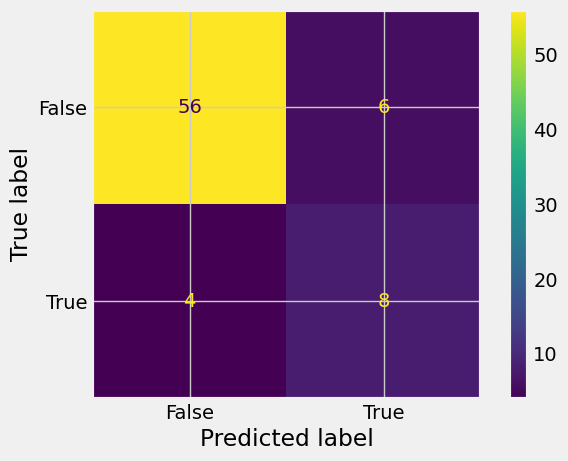

In [ ]:
# Calculate the confusion matrix for the test predictions
# 'confusion_matrix' compares the true labels (test_y) with the predicted labels (predictions)
# 'labels=cboost.classes_' specifies the class labels for the confusion matrix
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)

# Create a ConfusionMatrixDisplay object to visualize the confusion matrix
# 'confusion_matrix=cm' provides the confusion matrix data
# 'display_labels=cboost.classes_' specifies the class labels for display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)

# Plot the confusion matrix
disp.plot()

# Show the plot
plt.show()


## Feature Importance (Optional)

In [ ]:
features = x_df.columns
importances_cboost = cboost.feature_importances_

In [ ]:
# Create a dictionary to store the evaluation results of the CatBoost model
cboost_results = {
    'accuracy': accuracy,               # Accuracy of the model on the test set
    'model': 'CatBoost',                # Name of the model used
    'f1_score': F1,                     # F1 score of the model on the test set
    'training auc score': train_auc,    # AUC score on the training set
    'test auc score': test_auc           # AUC score on the test set
}

# Display the results dictionary containing model evaluation metrics
cboost_results

{'accuracy': 0.8648648648648649,
 'model': 'CatBoost',
 'f1_score': 0.6153846153846154,
 'training auc score': 0.9804649397476042,
 'test auc score': 0.8844086021505376}

After removing those features.
* f1 score fell below from 51 to 45.
* Overfitting reduced.

### K-fold cross validation (Optional)

To use K-fold cross validation, training data file can be split into train and test sets using train_test_split method.

In [ ]:
# Import the KFold class from sklearn.model_selection to perform K-Fold cross-validation
from sklearn.model_selection import KFold

# Initialize KFold with 10 splits and shuffle the data before splitting
# 'n_splits=10' specifies the number of folds to be created
# 'shuffle=True' ensures that the data is shuffled before splitting to promote randomness
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
for k, (train, test) in enumerate(kfold.split(x_df, y_df)):
    cboost.fit(x_df.iloc[train], y_df.iloc[train])
    print(f'iteration number = {k+1}')
    print(f'Training Accuracy = {cboost.score(x_df.iloc[train], y_df.iloc[train])}')
    print(f'Test Accuracy = {cboost.score(x_df.iloc[test], y_df.iloc[test])}')
    print(f'f1 score = {f1_score(test_y, predictions)}')

Streaming output truncated to the last 5000 lines.
20:	learn: 0.4593913	total: 26.6ms	remaining: 1.24s
21:	learn: 0.4551642	total: 27.6ms	remaining: 1.23s
22:	learn: 0.4507316	total: 28.6ms	remaining: 1.22s
23:	learn: 0.4473171	total: 29.8ms	remaining: 1.21s
24:	learn: 0.4438954	total: 30.7ms	remaining: 1.2s
25:	learn: 0.4406014	total: 31.6ms	remaining: 1.18s
26:	learn: 0.4373377	total: 32.4ms	remaining: 1.17s
27:	learn: 0.4348407	total: 33.3ms	remaining: 1.16s
28:	learn: 0.4322613	total: 34.2ms	remaining: 1.14s
29:	learn: 0.4296819	total: 35.3ms	remaining: 1.14s
30:	learn: 0.4259028	total: 36.4ms	remaining: 1.14s
31:	learn: 0.4238876	total: 37.5ms	remaining: 1.13s
32:	learn: 0.4216207	total: 38.4ms	remaining: 1.13s
33:	learn: 0.4196035	total: 39.3ms	remaining: 1.12s
34:	learn: 0.4172400	total: 40.1ms	remaining: 1.11s
35:	learn: 0.4148625	total: 40.9ms	remaining: 1.1s
36:	learn: 0.4122256	total: 41.8ms	remaining: 1.09s
37:	learn: 0.4101840	total: 42.6ms	remaining: 1.08s
38:	learn: 0.40

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost

**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [ ]:
# Copy dataframe
xgb_data = train_ibm_df.copy()

In [ ]:
# Handling categorical features
# Create dummy variables for categorical features in the dataset
# 'pd.get_dummies' converts categorical variables into dummy/indicator variables
# 'drop_first=True' removes the first category to avoid multicollinearity
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)

# Display the first few rows of the resulting dummy variable DataFrame
xgb_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
xgb_data = pd.concat([xgb_data, xgb_dummy], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Rename target column
xgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
xgb_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [ ]:
# Features
x_df = xgb_data.drop('attrition', axis=1)
# Targer label
y_df = xgb_data['attrition']

x_df.shape, y_df.shape

((1396, 44), (1396,))

In [ ]:
x_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,1.0,10.0,3.0,2,5,4.0,0.0,3.0,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,2.5,4.0,3.0,4,2,2.0,2.0,2.0,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


Unlike LightGBM, in XGB, one has to manually create dummy variable/ label encoding for categorical features before feeding them into the models

### SMOTE (Optional)

In [ ]:
# Import the SMOTE (Synthetic Minority Oversampling Technique) class from imblearn to address class imbalance
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object to create synthetic samples for the minority class
oversample = SMOTE()

# Apply SMOTE to the feature set (x_df) and target variable (y_df)
# 'fit_resample()' generates a balanced dataset by creating synthetic samples for the minority class
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

In [ ]:
y_df1.value_counts()

,count
attrition,
True,1171
False,1171


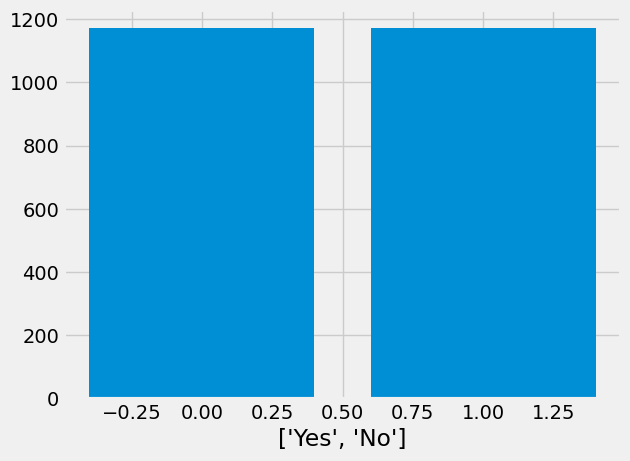

In [ ]:
plt.bar(y_df1.value_counts().index, y_df1.value_counts().values)
plt.xlabel(["Yes", "No"])
plt.show()

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

In [ ]:
# def xgb_objective(space):

#     model = XGBClassifier(
#         learning_rate = space['learning_rate'],
#         n_estimators = int(space['n_estimators']),
#         max_depth = int(space['max_depth']),
#         min_child_weight = space['m_child_weight'],
#         gamma = space['gamma'],
#         subsample = space['subsample'],
#         scale_pos_weight = 6,
#         colsample_bytree = space['colsample_bytree'],
#         objective = 'binary:logistic'
#     )

#     model.fit(x_df, y_df)

#     predictions = model.predict(test_x)
#     test_preds = model.predict_proba(test_x)[:,1]
#     train_preds = model.predict_proba(x_df)[:,1]

#     xgb_booster = model.get_booster()
#     train_auc = roc_auc_score(y_df, train_preds)
#     test_auc = roc_auc_score(test_y, test_preds)
#     accuracy = accuracy_score(test_y, predictions)
#     F1 = f1_score(test_y, predictions)

#     return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
#             'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1
#            }

In [ ]:
# Define a search space for hyperparameter optimization using Hyperopt
space = {
    # Number of trees in the ensemble (n_estimators) from 50 to 1000 with step size of 25
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),

    # Maximum depth of a tree (max_depth) ranging from 1 to 12
    'max_depth': hp.quniform('max_depth', 1, 12, 1),

    # Minimum child weight (m_child_weight) from 1 to 6
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),

    # Minimum loss reduction required to make a further partition (gamma) ranging from 0.5 to 1
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),

    # Subsample ratio of the training instances (subsample) ranging from 0.5 to 1
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),

    # Learning rate (learning_rate) sampled from a log-uniform distribution between 0.001 and 0.3
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),

    # Subsample ratio of columns when constructing each tree (colsample_bytree) ranging from 0.5 to 1
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

In [ ]:
trials = Trials()

In [ ]:
# xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
# display(xgb_results)

In [ ]:
# Create XGBoost classifier model
xgb_model = XGBClassifier(
    learning_rate = 0.14972574734435318,
    n_estimators = 200,
    max_depth = 1,
    min_child_weight = 6,
    gamma = 0.5,
    subsample = 0.55,
    colsample_bytree = 1,
    scale_pos_weight = 6,
    objective = 'binary:logistic'
)

In [ ]:
x_df.shape, y_df.shape

((1396, 44), (1396,))

In [ ]:
xgb_model.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14972574734435318, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_model_dft = XGBClassifier()

In [ ]:
xgb_model_dft.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Performance

In [ ]:
# Model performance on all sets
predictions = xgb_model.predict(test_x)
test_preds = xgb_model.predict_proba(test_x)[:,1]
train_preds = xgb_model.predict_proba(x_df)[:,1]

xgb_booster = xgb_model.get_booster()

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6666666666666666


Confusion Matrix

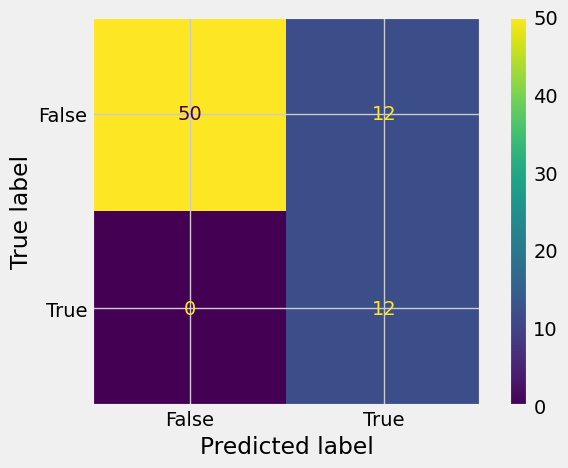

In [ ]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

### Feature Importance

In [ ]:
features = x_df.columns
importances_xgboost = xgb_model.feature_importances_

In [ ]:
xgb_results = {'accuracy': accuracy,
              'model': 'XGBoost',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}
xgb_results

{'accuracy': 0.8378378378378378,
 'model': 'XGBoost',
 'f1_score': 0.6666666666666666,
 'test auc score': 0.9502688172043011,
 'training auc score': 0.9055508112724168}

f1 score fell below, from 51 to 50.
* Overfitting is unaffected.

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [ ]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
lgb_data = train_ibm_df.copy()

# Handling categorical features
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)

# Concat the dummy variables to actual dataframe and remove initial categorical columns
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)

# Rename target column
lgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)

# Features
x_df = lgb_data.drop(columns='attrition')
# Target lebel
y_df = lgb_data['attrition'].reset_index(drop=True)
x_df.shape, y_df.shape

((1396, 44), (1396,))

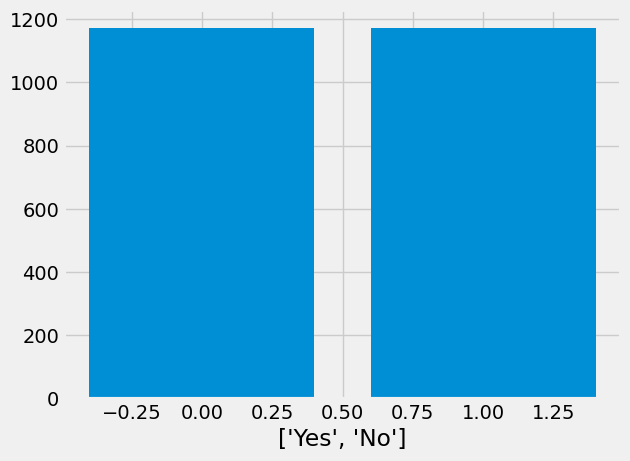

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

plt.bar(y_df1.value_counts().index, y_df1.value_counts().values)
plt.xlabel(["Yes", "No"])
plt.show()

### Model Definition

In [ ]:
def lgb_objective(space):

    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        scale_pos_weight = 5,
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )

    lgbm.fit(x_df, y_df)

    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(x_df)[:,1]

    train_auc = roc_auc_score(y_df, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1

           }

In [ ]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective,
                 max_evals = 150,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

In [ ]:
# # Create LightGBM classifier model
# lgbm = LGBMClassifier(
#     learning_rate = 0.15828893812295405,
#     n_estimators= 825,
#     max_depth = 8,
#     num_leaves = 110,
#     colsample_bytree = 0.6839759118900923,
#     feature_fraction = 0.3930665137463929,
#     reg_lambda = 0.8857198279892347,
#     reg_alpha = 0.8003856547872137,
#     min_split_gain = 0.07737786522996747
# )

In [ ]:
# Create LightGBM classifier model
lgbm = LGBMClassifier(
    learning_rate = 1,
    n_estimators= 100,
    max_depth = 3,
    num_leaves = 31,
    colsample_bytree = 1,
    reg_lambda = 30,
    scale_pos_weight = 5,
    reg_alpha = 30,
    min_split_gain = 3
)

In [ ]:
lgbm.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(colsample_bytree=1, learning_rate=1, max_depth=3,
               min_split_gain=3, reg_alpha=30, reg_lambda=30,
               scale_pos_weight=5)

In [ ]:
lgbm_dft = LGBMClassifier()

In [ ]:
lgbm_dft.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513


LGBMClassifier()

### Model performance

In [ ]:
# Model performance on all sets
predictions = lgbm.predict(test_x)
test_preds = lgbm.predict_proba(test_x)[:,1]
train_preds = lgbm.predict_proba(x_df1)[:,1]

train_auc = roc_auc_score(y_df1, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.27906976744186046


Confusion Matrix

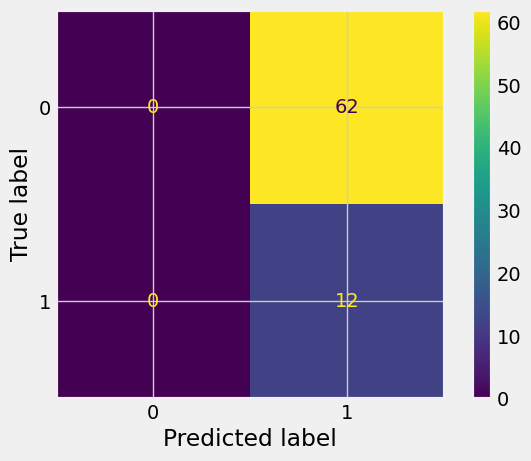

In [ ]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

## Feature Importance

In [ ]:
features = x_df.columns
importances_lgbm = lgbm.feature_importances_

In [ ]:
lgbm_results = {'accuracy': accuracy,
              'model': 'LightGBM',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}

lgbm_results

{'accuracy': 0.16216216216216217,
 'model': 'LightGBM',
 'f1_score': 0.27906976744186046,
 'test auc score': 0.3064516129032258,
 'training auc score': 0.7379373866446526}

f1 score drastically fell.
* Overfiiting is unaffected.

### Importances Dataframe

In [ ]:
importances_cboost

array([7.67273853, 9.02456938, 3.38852629, 0.11750302, 3.29953302,
       5.88569465, 2.50502377, 5.60527495, 2.29552299, 8.43645154,
       6.37030637, 2.16996699, 2.74905082, 0.        , 1.69144306,
       0.        , 4.27009453, 2.25703515, 1.08730227, 1.40120466,
       2.51708016, 2.36745326, 1.74767643, 5.63502807, 2.0876631 ,
       0.63088038, 2.9265668 , 0.15873884, 0.13048199, 0.17604423,
       0.02736759, 0.        , 0.93438973, 0.45934451, 0.27976257,
       0.79721333, 0.        , 0.18863242, 0.40082477, 0.75143236,
       0.01587939, 0.10743704, 0.25571134, 0.28036818, 6.8967815 ])

In [ ]:
print(np.round(importances_xgboost*100))

[3. 2. 3. 0. 4. 1. 3. 3. 3. 3. 2. 3. 2. 0. 3. 0. 6. 3. 2. 2. 4. 2. 2. 4.
 4. 0. 3. 2. 1. 2. 2. 0. 3. 2. 0. 2. 2. 2. 0. 2. 0. 2. 1. 4. 5.]


In [ ]:
importances_lgbm

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
       1, 1, 0, 2, 0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0,
       1], dtype=int32)

In [ ]:
print(np.round(importances_cboost))

[8. 9. 3. 0. 3. 6. 3. 6. 2. 8. 6. 2. 3. 0. 2. 0. 4. 2. 1. 1. 3. 2. 2. 6.
 2. 1. 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 7.]


In [ ]:
importances_df = pd.DataFrame()
importances_df['Feature Name'] = features
importances_df['Feature Imp CBoost'] = np.round(importances_cboost)
importances_df['Feature Imp XGBoost'] = np.round(importances_xgboost*100)
importances_df['Feature Imp LightBoost'] = importances_lgbm
importances_df.sort_values(['Feature Imp CBoost', 'Feature Imp XGBoost', 'Feature Imp LightBoost'], ascending=False)

,Feature Name,Feature Imp CBoost,Feature Imp XGBoost,Feature Imp LightBoost
1,businesstravel_Travel_Rarely,9.0,2.0,0
0,businesstravel_Travel_Frequently,8.0,3.0,1
9,gender_Male,8.0,3.0,0
44,yearswithcurrmanager,7.0,5.0,1
23,distancefromhome,6.0,4.0,1
7,educationfield_Other,6.0,3.0,0
10,jobrole_Human Resources,6.0,2.0,0
5,educationfield_Marketing,6.0,1.0,0
16,jobrole_Sales Executive,4.0,6.0,0
20,overtime_Yes,3.0,4.0,1


## Results

**Exercise 12: Create a dataframe of XGBoost results, LightGBM results, CatBoost results and display them [0.5 Mark]**

In [ ]:
# Create a dataframe for computed metrics for different models
final_results = pd.DataFrame([xgb_results, lgbm_results, cboost_results])
display(final_results)

,accuracy,model,f1_score,test auc score,training auc score
0,0.878378,XGBoost,0.727273,0.943548,0.905278
1,0.162162,LightGBM,0.279070,0.306452,0.737937
2,0.864865,CatBoost,0.615385,0.884409,0.980465


- XGBoost is a wonderful algorithm with great documentation and many examples from years of use.
- LightGBM was clearly the fastest algorithm, often being 10x faster than XGBoost.
- In terms of accuracy the test and train dataset often had different balances of minority and majority class so 1-to-1 comparisons aren't perfect.
- CatBoost was the algorithm one can be most interested in using because of the supposed innovations in working with categorical data. Despite good accuracy however, several problems were faced.

    - CatBoost seemed significantly slower than the other algorithms, it seemed to stall on some evaluations. More experimentation may be needed with CatBoost and data that had lots of categorical features to get a better feel for when it may perform best.

* SMOTE was used to handle imabalance, it had no effect on the performance of all the three models.
* Using POS weight parameter to handle imabalace in all the three models helps give good results.
* K-fold cross validation technique was used while using train test split, performance of the model dipped.
* Outliers were handled but it had least effect on the performance.
* Three irrelevant features were dropped, it had no effect on the model performance.
* By far CatBoost is the best performing model followed by XGBoost whereas CatBoost takes longer to optimize parameters using Hyperopt, it is quick with XGBoost.
* Feature importance was calculated for all the three models.
* Based upon the importance 5 features were identified as not important. Removing these features while training dipped the performance of the models.

References:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/